# Investigating the correlation between plant pairs (related by genus) and their growth conditions 

### Import modules

In [1]:
import logging
from collections import defaultdict
import json
import pandas as pd
from tqdm import tqdm

# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats.stats import pearsonr  

/Users/danieldomingo/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline

In [3]:
logging.disable()
pd.options.mode.chained_assignment = None

In [4]:
DATA_DIR = '../data/processed'
MAPPING_DIR = '../data/mapping'

### Load plant-disease evidences

In [5]:
literature_pairs = pd.read_csv(
    f'{DATA_DIR}/literature_based_correlation_data.tsv.gz',
    sep='\t'
)

literature_pairs_genus = literature_pairs[literature_pairs['pair_type'] == 'Same genus']
literature_pairs_genus.shape

(10962, 4)

In [6]:
database_pairs = pd.read_csv(
    f'{DATA_DIR}/database_based_correlation_data.tsv.gz',
    sep='\t'
)

database_pairs_genus = database_pairs[database_pairs['pair_type'] == 'Same genus']
database_pairs_genus.shape

(3533, 4)

In [7]:
medicinal_plants_lit = set(literature_pairs_genus['plant_1'].tolist()).union(
    literature_pairs_genus['plant_2'].tolist()
)

medicinal_plants_database = set(database_pairs_genus['plant_1'].tolist()).union(
    database_pairs_genus['plant_2'].tolist()
)

medicinal_plants = medicinal_plants_lit.union(medicinal_plants_database)

len(medicinal_plants)

4004

### Loading plant location data

In [8]:
ncbi_ids_trefle = json.load(open(f'{MAPPING_DIR}/trefle_grounding.json'))

In [9]:
trefle_df = pd.read_csv(
    '../data/raw/trefle_species_dump.csv', 
    sep='\t', 
    usecols=[
        'scientific_name', 
        'light', 
        'soil_nutriments',
        'atmospheric_humidity', 
        'ph_maximum', 
        'ph_minimum',
    ],
    low_memory=False
)

In [10]:
# Fix scientific names and drop subspecies
trefle_df['scientific_name'] = trefle_df['scientific_name'].str.replace('?', '')

trefle_df['ncbi_ids'] = trefle_df['scientific_name'].map(lambda x: ncbi_ids_trefle[x][0])
trefle_df = trefle_df[trefle_df['ncbi_ids'].isin(medicinal_plants)]
trefle_df.head(3)

,scientific_name,light,soil_nutriments,atmospheric_humidity,ph_maximum,ph_minimum,ncbi_ids
0,Abies balsamea,7.0,5.0,5.0,6.0,4.0,ncbitaxon:90345
4,Abies grandis,7.0,5.0,6.0,7.5,4.5,ncbitaxon:46611
29,Abutilon theophrasti,8.0,6.0,4.0,8.0,7.5,ncbitaxon:3631


In [11]:
trefle_df.dropna(how='any', inplace=True)

In [12]:
## Blacklist -- removal of subspecies or incorrect names from database list
blacklist = [
    'Cardamine pratensis subsp. paludosa',
    'Cardamine pratensis subsp. matthioli',
    'Quercus robur subsp. robur',
    'Melilotus indica',
    'Lotus corniculatus subsp. corniculatus',
    'Dactylorhiza incarnata subsp. incarnata',
    'Raphanus raphanistrum subsp. sativus',
    'Xanthium strumarium subsp. brasilicum',
    'Centaurea solstitialis subsp. solstitialis',
    'Salicornia europaea subsp. disarticulata',
    'Carex capillaris subsp. capillaris'
]

trefle_df = trefle_df[~trefle_df['scientific_name'].isin(blacklist)]

In [13]:
trefle_df.head(2)

,scientific_name,light,soil_nutriments,atmospheric_humidity,ph_maximum,ph_minimum,ncbi_ids
0,Abies balsamea,7.0,5.0,5.0,6.0,4.0,ncbitaxon:90345
4,Abies grandis,7.0,5.0,6.0,7.5,4.5,ncbitaxon:46611


In [14]:
plants_with_info = set(trefle_df['ncbi_ids'].tolist())
len(plants_with_info)

518

In [15]:
trefle_df.shape

(518, 7)

## Clustering with respect to diseases

In [16]:
plant_chemical_df = pd.read_csv(
    f'{DATA_DIR}/plant_chemical_associations.tsv.zip',
    sep='\t',
    compression='zip',
    low_memory=False,
)

## Drop plants that do not have the respective plant information
plant_chemical_df = plant_chemical_df[plant_chemical_df.plant_curie.isin(plants_with_info)]

## Clustering with respect to chemicals

In [17]:
plant_chemical_matrix = pd.DataFrame(
    0, 
    index=plant_chemical_df.chemical_curie.unique(),
    columns=plant_chemical_df.plant_curie.unique(),
)

plant_chemical_matrix.head(2)

,ncbitaxon:101996,ncbitaxon:103355,ncbitaxon:105884,ncbitaxon:1060938,ncbitaxon:113202,ncbitaxon:113538,ncbitaxon:113636,ncbitaxon:114937,ncbitaxon:121718,ncbitaxon:123597,...,ncbitaxon:84009,ncbitaxon:86306,ncbitaxon:89585,ncbitaxon:90345,ncbitaxon:90364,ncbitaxon:90446,ncbitaxon:91242,ncbitaxon:93026,ncbitaxon:93692,ncbitaxon:97307
pubchem.compound:415565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pubchem.compound:348157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
for plant_curie, chemical_curie in tqdm(plant_chemical_df[['plant_curie', 'chemical_curie']].values):    
    plant_chemical_matrix.loc[chemical_curie, plant_curie] = 1

100%|██████████| 27783/27783 [00:03<00:00, 8911.54it/s]


In [31]:
plant_chemical_matrix.shape

(13164, 452)

In [32]:
plant_chemical_similarity_matrix = plant_chemical_matrix.corr()

In [33]:
plant_chemical_similarity_matrix.shape

(452, 452)

In [35]:
plant_climatic_matrix = trefle_df[[
    'ncbi_ids',
    'light',
    'soil_nutriments',
    'atmospheric_humidity',
    'ph_maximum',
    'ph_minimum',
]]

plant_climatic_matrix.set_index('ncbi_ids', inplace=True)

#Look at the union of plants (plants with chemicals and also climatic info)
keep_rows = plant_climatic_matrix.index.isin(plant_chemical_similarity_matrix.index)

plant_climatic_matrix = plant_climatic_matrix[keep_rows]

In [36]:
assert plant_climatic_matrix.shape[0] == plant_chemical_similarity_matrix.shape[0], 'error with matrix size'

In [37]:
plant_climatic_similarity_matrix = plant_climatic_matrix.T.corr()

In [38]:
plant_climatic_similarity_matrix.shape

(452, 452)

In [39]:
average_correlation = []

for index in plant_climatic_similarity_matrix.index:
    
    climatic_vector = plant_climatic_similarity_matrix[index]
    chemical_vector = plant_chemical_similarity_matrix[index]
    
    corr, _ = pearsonr(climatic_vector, chemical_vector)
    
    average_correlation.append(corr)

In [40]:
np.mean(average_correlation)

-0.004500335399145856

/Users/danieldomingo/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

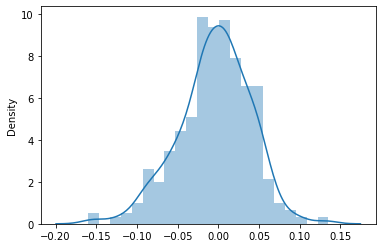

In [41]:
sns.distplot(average_correlation)